# TODO
This notebook in itself is not very interactive, as it only uses the analytics_stat.distributions module to fit the distributions to a TTF (Time to failure) set. Therefore the work to be done here is mainly in the distributions module, as this notebook doesn't necessarily have to be more complex
* Change the distributions fitting method so it isn't stochastic and use the relationship between parameters to calculate them (Most likelihood estimation method)
* Comment the code and refactor

In [1]:
import sys 
sys.path.append(r'/home/emanuel/Desktop/Reliability-app/bin')

In [2]:
import analytics_stat.distributions as di

import warnings
warnings.filterwarnings('ignore')

import datetime
import scipy.stats as s
#import scipy.optimize as opt
#import scipy.special as special
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib inline
# %matplotlib notebook

import os
import json
import pandas as pd
import qgrid
from IPython.display import HTML, Image, display, clear_output
from ipywidgets import Output
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

display(HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
This report hides the raw code used for its implementation by default.
To hide/show the raw code, click <a href="javascript:code_toggle()">here</a>.'''))



In [80]:
from importlib import reload

In [81]:
reload(di)

<module 'analytics_stat.distributions' from '/home/emanuel/Desktop/Reliability-app/bin/analytics_stat/distributions.py'>

In [5]:
out = Output()

In [7]:
import traitlets
from tkinter import Tk, filedialog


class Plotting:
    
    def __init__(self):
        pass
    
    def plot_line(self, json, x, y, name):
        x = json.x
        y = json.y
        name = json.name
        trace_line = go.Scatter(x = x, y = y, mode = 'lines', opacity = 0.8, name = name, xaxis = 'x', yaxis = 'y')
        
    def plot_scatter(self,  x, y, name):
        x = json.x
        y = json.y
        name = json.name
        trace_scatter = go.Scatter(x = x, y = y, mode = 'markers', opacity = 0.8, name = fn, xaxis = 'x', yaxis = 'y')
        
    def plot_histogram(self,  x, name, normed):
        x= json.x
        normed = json.type  # 'probability'
        trace_histogram = go.Histogram(x=x, histnorm=normed)
                           
    def create_layout(self, title, xlabel, ylabel):
        title = json.title
        xlabel = json.xlabel
        ylabel = json.ylabel
        layout = Layout(title=title, yaxis=dict(title=ylabel)) 
        
    def draw(self,trace,layout):
        fig = go.Figure(data = [trace_histogram],layout=layout)
        py.iplot(fig)


class StatPlot(Plotting):
    
    def __init__(self):
        
        pass
    
    def pdf(self, json):
        
        pdf_mle = dist_funs[dist_index[0]].pdf(params_dist_mle,  x_plot)



class Display:
    
    def __init__(self):
        self.out = out
        # Clear Output button
        self._blo = widgets.Button(layout=widgets.Layout(width='500px',height='50px'))
        self._blo.description = "Clear Output"
        self._blo.icon = 'download'
        self._blo.on_click(self.clear_output)
        self._blo.disabled = False
        
        # Select file button
        self._bsf = widgets.Button(layout=widgets.Layout(width='500px',height='50px'))
        self._bsf.add_traits(files=traitlets.traitlets.List())
        self._bsf.description = "Select File"
        self._bsf.icon = "square-o"
        self._bsf.on_click(self.select_json)
        
        
        # Load Json button
        self._blj = widgets.Button(layout=widgets.Layout(width='500px',height='50px'))
        self._blj.description = "Load File"
        self._blj.icon = 'download'
        self._blj.on_click(self.load_json)
        self._blj.disabled = True
        
        # Rank distributions button
        self._brd = widgets.Button(layout=widgets.Layout(width='500px',height='50px'))
        self._brd.description = 'Rank Distributions'
        self._brd.icon = "area-chart"
        self._brd.on_click(self.rank_distributions)
        self._brd.disabled = True
        
        # Select distributions
        self._sdist = widgets.SelectMultiple(
                    options=['weibull3p', 'weibull2p', 'normal', 'lognormal',
                  'exponential1p', 'exponential2p', 'logistic', 'loglogistic'],
                    value=['weibull3p', 'weibull2p', 'normal', 'lognormal',
                  'exponential1p', 'exponential2p', 'logistic', 'loglogistic'],
                    description='Dist. functions:',
                    disabled=True,
                    )
        
        # Save model button
        self._bsm = widgets.Button(layout=widgets.Layout(width='500px',height='50px'))
        self._bsm.description = 'Save Best Model'
        self._bsm.icon = "floppy-o"
        self._bsm.on_click(self.save_model_json)
        self._bsm.disable = True
        
        # define layout
        box_layout = widgets.Layout(display='center',
                            flex_flow='row',
                            align_items='center',
                            border='None',
                            justify_content='space-between',
                            width='800px')
        
        self._box = widgets.Box(children=[self._bsf, self._blj, self._sdist, self._brd, self._bsm, self._blo ], layout=box_layout)
        display(self._box)
        display(self.out)
        
    def clear_output(self, b):
        self.out.clear_output()
        
    def select_json(self,b): 
        # Create Tk root
        root = Tk()
        # Hide the main window
        root.withdraw()
        # Raise the root to the top of all windows.
        root.call('wm', 'attributes', '.', '-topmost', True)
        
        new_file = filedialog.askopenfilename(multiple=True,filetypes = [("JSON",'*.json')])
        if new_file != "":
            self._bsf.files = new_file

        print('Selected file: {}'.format(self._bsf.files ))

        self._bsf.description = "Files Selected"
        self._bsf.icon = "check-square-o"
        self._bsf.button_style = "success"
        
        self._blj.disabled = False
        
    def load_json(self, b):
        
        file_path = self._bsf.files
        if (type(file_path) == list) and (len(file_path)>0):
            with open(file_path[0], 'r') as f:
                self._json_file = json.load(f)
            
            self._failure_mode = np.array(self._json_file['is_failure'])
            self._ttf = np.array(self._json_file['ttf'])
            self._client = self._json_file['client_name']
            self._clientid = self._json_file['client_id']
            self._symptom = self._json_file['symptom']
                
            self._sdist.disabled = False
            self._brd.disabled = False
            self._blj.button_style = "success"
#             print('JSON loaded.')
        else:
            print('Select file.')
            
            
    def save_model_json(self, b):
        json_model = dict()
        json_model['version'] = 0.1 
        json_model['saved_time'] = str(datetime.datetime.now())
        
        if self._symptom is None:
            json_model['symptom'] = None
        elif isinstance(self._symptom, int):
            json_model['symptom'] = int(self._symptom)
        elif isinstance(self._symptom, list):
            json_model['symptom'] = self._symptom
        else:
            raise TypeError('Undefined type for Symptom')
            
        json_model['client_id'] = int(self._clientid)
        json_model['client_name'] = self._client
        
        json_model['input_json'] = os.path.splitext(os.path.basename(d._bsf.files[0]))[0]
        json_model['competing_models'] = list(self._sdist.value)
        
        json_model['best_model'] = dict()
        json_model['best_model']['law'] = self._combs[0].iloc[0].name
        json_model['best_model']['MLE'] = dict()
        json_model['best_model']['MLE']['params'] = self._res_mle[json_model['best_model']['law']]['params']
        json_model['best_model']['MLE']['goodness_of_fit'] = self._res_mle[json_model['best_model']['law']]['goodness_of_fit']
        
        json_model['best_model']['LSQ'] = dict()
        json_model['best_model']['LSQ']['params'] = self._res_ls[json_model['best_model']['law']]['params']
        json_model['best_model']['LSQ']['goodness_of_fit'] = self._res_ls[json_model['best_model']['law']]['goodness_of_fit']
                                
        with open("../data/results/models/model_{}_{}.json".format(json_model['input_json'],
                                                           json_model['best_model']['law']), 'w') as f:
            json.dump(json_model, f)
        
        self._bsm.button_style = 'success'
    @out.capture(clear_output=True, wait = True)
    def rank_distributions(self, b):
        print('Ranking from Maximum Likelihood Estimation fitting:')
        self._res_mle = di.rank_dist(self._ttf, method='MLE',
                                     distributions=list(self._sdist.value))

#         print('')
#         print(self._res_mle)
#         print('')

        print('Ranking from Least Squares fitting:')
        self._res_ls = di.rank_dist(self._ttf, method='lsq', 
                                    distributions=list(self._sdist.value))
#         print(self._res_ls)
#         print('')
        print('Ranking from the combination of both methods:')
        self._combs = di.combine_ranks(res_mle=self._res_mle, 
                                       res_ls=self._res_ls, display=True)
        
        di.plot_best(self._combs[0], self._ttf)
        
        self._brd.button_style = "success"
        self._bsm.disabled = False
        
#         print(self._combs)

# Fitting distributions to reliability data (Life data)

The database is one vector of "Time to Failure" values, given in periods of either seconds, minutes, hours, days, weeks, months, years. The found data-sets comprise hours of functioning which are $\Delta t$ between system failure and previous repair. 

MTTF – Mean Time To Failure (TTF – time to fail) can be interpreted as the difference between the time of a failure and the time of putting the system at work after a repairing event, as depicted in the figure bellow.



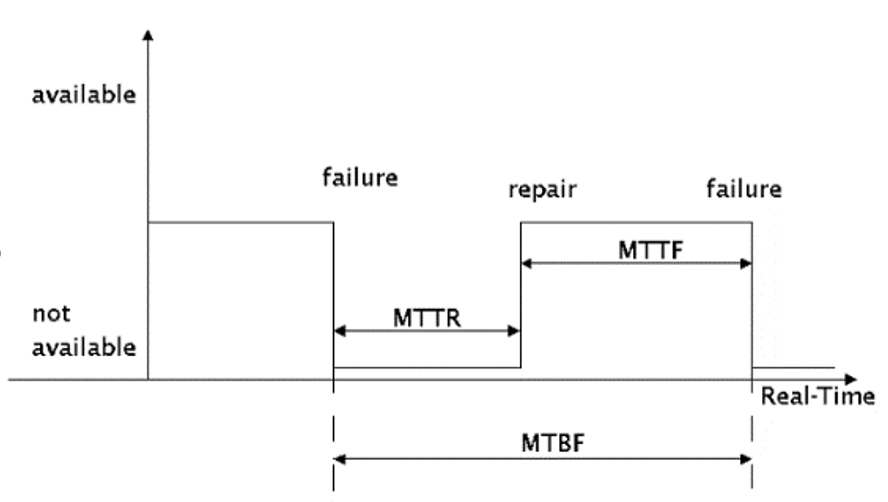

In [8]:
display(Image('../imgs/ttf_example.png', width=500))

In [9]:
d = Display()

Box(children=(Button(description='Select File', icon='square-o', layout=Layout(height='50px', width='500px'), …

Output()

Selected file: ['/home/emanuel/Desktop/Reliability-app/data/results/ttf/ttf_symptomNone_client5.json']


### Data statistical summary:

In [12]:
perc = np.linspace(0,1-1e-3,10)
perc = np.array([0.01,.1,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,85,90,95,99,99.9,99.99])/100

In [13]:
percentile = di.Weibull().ppf([0.71616389532044444, 15.357402922686479, 0.99850129555238953],perc)

In [14]:
table_of_percentiles = pd.DataFrame({'BX%':perc*100,'Percentile (t)':percentile})
table_of_percentiles

,BX%,Percentile (t)
0,0.01,0.998541
1,0.10,0.999496
2,1.00,1.023430
3,2.00,1.064588
4,3.00,1.115745
5,4.00,1.174971
6,5.00,1.241240
7,6.00,1.313915
8,7.00,1.392565
9,8.00,1.476886


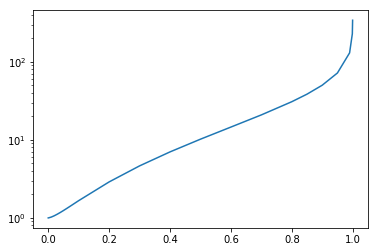

In [15]:
fig, ax = plt.subplots()

ax.semilogy(perc, percentile)

In [16]:
sys.path

['',
 '/home/emanuel/spark-2.3.1-bin-hadoop2.7/python',
 '/home/emanuel/spark-2.3.1-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip',
 '/home/emanuel/Desktop/Reliability-app/notebooks',
 '/home/emanuel/anaconda3/lib/python36.zip',
 '/home/emanuel/anaconda3/lib/python3.6',
 '/home/emanuel/anaconda3/lib/python3.6/lib-dynload',
 '/home/emanuel/.local/lib/python3.6/site-packages',
 '/home/emanuel/anaconda3/lib/python3.6/site-packages',
 '/home/emanuel/anaconda3/lib/python3.6/site-packages/IPython/extensions',
 '/home/emanuel/.ipython',
 '..\\bin',
 '..Desktop\\bin',
 '..\\bin',
 '/home/emanuel/Desktop/Reliability-app/bin',
 '/home/emanuel/Desktop/Reliability-app/bin']

In [12]:
x = np.array(None)

In [13]:
np.nan_to_num(x)

array(None, dtype=object)